In [7]:
!pip install tensorflow

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df = pd.read_csv('HomeC.csv', low_memory=False)
df = df[:-1]
df['time'] = pd.to_numeric(df['time'])
df['Timestamp'] = pd.to_datetime(df['time'], unit='s')
df.set_index('Timestamp', inplace=True)
print(df.head())

                           time  use [kW]  gen [kW]  House overall [kW]  \
Timestamp                                                                 
2016-01-01 05:00:00  1451624400  0.932833  0.003483            0.932833   
2016-01-01 05:00:01  1451624401  0.934333  0.003467            0.934333   
2016-01-01 05:00:02  1451624402  0.931817  0.003467            0.931817   
2016-01-01 05:00:03  1451624403  1.022050  0.003483            1.022050   
2016-01-01 05:00:04  1451624404  1.139400  0.003467            1.139400   

                     Dishwasher [kW]  Furnace 1 [kW]  Furnace 2 [kW]  \
Timestamp                                                              
2016-01-01 05:00:00         0.000033        0.020700        0.061917   
2016-01-01 05:00:01         0.000000        0.020717        0.063817   
2016-01-01 05:00:02         0.000017        0.020700        0.062317   
2016-01-01 05:00:03         0.000017        0.106900        0.068517   
2016-01-01 05:00:04         0.000133      

time                     int64
use [kW]               float64
gen [kW]               float64
House overall [kW]     float64
Dishwasher [kW]        float64
Furnace 1 [kW]         float64
Furnace 2 [kW]         float64
Home office [kW]       float64
Fridge [kW]            float64
Wine cellar [kW]       float64
Garage door [kW]       float64
Kitchen 12 [kW]        float64
Kitchen 14 [kW]        float64
Kitchen 38 [kW]        float64
Barn [kW]              float64
Well [kW]              float64
Microwave [kW]         float64
Living room [kW]       float64
Solar [kW]             float64
temperature            float64
icon                    object
humidity               float64
visibility             float64
summary                 object
apparentTemperature    float64
pressure               float64
windSpeed              float64
cloudCover              object
windBearing            float64
precipIntensity        float64
dewPoint               float64
precipProbability      float64
dtype: o

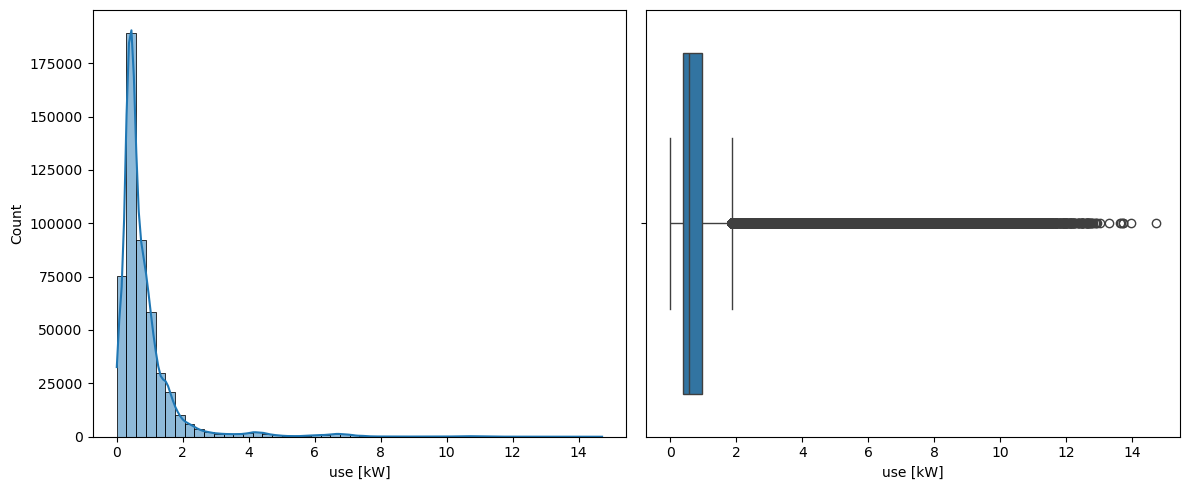

In [9]:
print(df.dtypes)
print(df.isnull().sum())
df.ffill(inplace=True)
print(df.duplicated().sum())
if df.duplicated().sum() > 0:
    df.drop_duplicates(inplace=True)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['use [kW]'], bins=50, kde=True)
plt.subplot(1, 2, 2)
sns.boxplot(x=df['use [kW]'])
plt.tight_layout()
plt.show()

(503910, 32)
(140, 29)


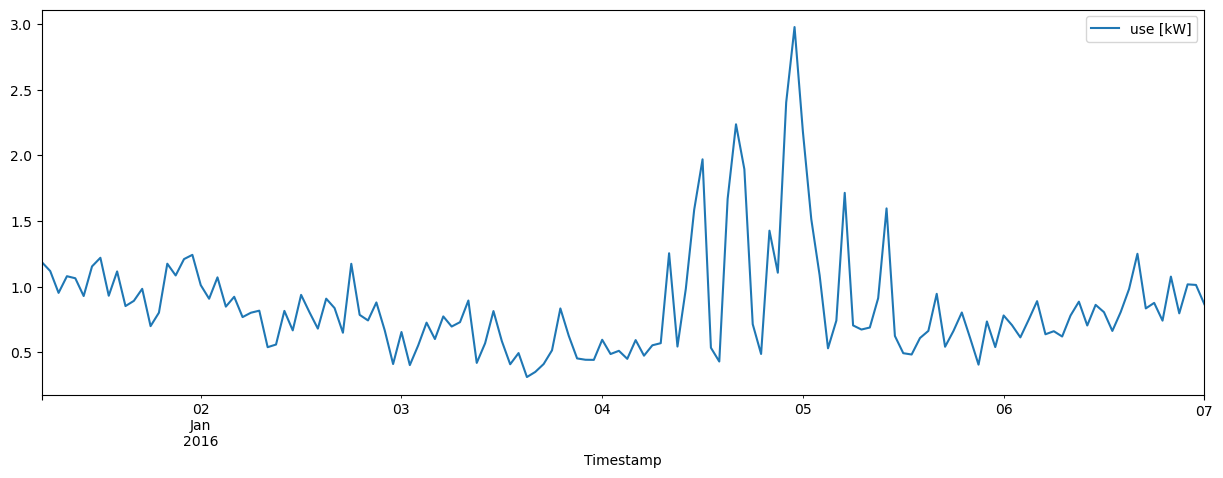

In [10]:
numeric_cols = df.select_dtypes(include=[np.number])
df_hourly = numeric_cols.resample('h').mean()
print(df.shape)
print(df_hourly.shape)
df_hourly[['use [kW]']].plot(figsize=(15, 5))
plt.show()

In [11]:
df_hourly.to_csv('clean_energy_data.csv')
print("Success! Your clean data is saved as 'clean_energy_data.csv'")

Success! Your clean data is saved as 'clean_energy_data.csv'


In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_array = scaler.fit_transform(df_hourly)
df_scaled = pd.DataFrame(df_scaled_array, columns=df_hourly.columns, index=df_hourly.index)

print(df_scaled.max().head())
print(df_scaled.min().head())

df_scaled.to_csv('scaled_energy_data.csv')

time                  1.0
use [kW]              1.0
gen [kW]              1.0
House overall [kW]    1.0
Dishwasher [kW]       1.0
dtype: float64
time                  0.0
use [kW]              0.0
gen [kW]              0.0
House overall [kW]    0.0
Dishwasher [kW]       0.0
dtype: float64


In [13]:
train_size = int(len(df_scaled) * 0.8)
train_data = df_scaled.iloc[:train_size]
test_data = df_scaled.iloc[train_size:]

print(train_data.shape)
print(test_data.shape)

train_data.to_csv('train_data.csv')
test_data.to_csv('test_data.csv')

(112, 29)
(28, 29)


In [14]:
import pandas as pd

# 1. Load the Scaled Data from Module 2
# We use index_col=0 and parse_dates=True so pandas understands the Timestamp index
train_df = pd.read_csv('train_data.csv', index_col=0, parse_dates=True)
test_df = pd.read_csv('test_data.csv', index_col=0, parse_dates=True)

def create_features(df):
    """
    Module 3: Feature Engineering
    - Extracts time features (Task 1)
    - Aggregates devices (Task 2)
    - Creates lags/rolling means (Task 3)
    """
    df = df.copy()
    # --- Task 1: Extract Relevant Time-Based Features ---
    # We divide by the max value (e.g., 23 for hour) to keep features between 0 and 1.
    # This matches the scale of your energy data, preventing model confusion.
    df['hour'] = df.index.hour / 23.0
    df['day_of_week'] = df.index.dayofweek / 6.0
    df['day_of_month'] = df.index.day / 31.0
    df['month'] = df.index.month / 12.0
    # --- Task 2: Aggregate Device-Level Consumption Statistics ---
    # Combine related circuits into meaningful groups so the model sees stronger patterns.
    # (Note: These column names must match your CSV headers exactly)
    df['Kitchen_Total_kW'] = df['Kitchen 12 [kW]'] + df['Kitchen 14 [kW]'] + df['Kitchen 38 [kW]']
    df['Furnace_Total_kW'] = df['Furnace 1 [kW]'] + df['Furnace 2 [kW]']
    # --- Task 3: Create Lag Features and Moving Averages ---
    # Lag 1: Usage 1 hour ago (Immediate history)
    df['lag_1h'] = df['use [kW]'].shift(1)
    # Lag 24: Usage 24 hours ago (Daily cycle pattern)
    df['lag_24h'] = df['use [kW]'].shift(24)
    # Rolling Mean: Average usage of the previous 3 hours (Trend smoothing)
    df['rolling_mean_3h'] = df['use [kW]'].rolling(window=3).mean()
    # --- Task 4: Prepare Final Feature Set ---
    # Drop rows with NaN (Not a Number) created by shifting/rolling
    # (The first 24 rows will be lost because they don't have enough history for lag_24h)
    df.dropna(inplace=True)
    return df
# Apply the function to both Train and Test datasets
train_features = create_features(train_df)
test_features = create_features(test_df)
# Print verification to show the work is done
print("Final Training Set Shape:", train_features.shape)
print("Final Testing Set Shape:", test_features.shape)
# Show all columns to prove nothing was removed
print("\nAll Available Features:")
print(train_features.columns.tolist())
# Save the final processed files for Module 4
train_features.to_csv('train_features.csv')
test_features.to_csv('test_features.csv')
print("\nSuccess: Module 3 complete. Data saved for modeling.")

Final Training Set Shape: (88, 38)
Final Testing Set Shape: (4, 38)

All Available Features:
['time', 'use [kW]', 'gen [kW]', 'House overall [kW]', 'Dishwasher [kW]', 'Furnace 1 [kW]', 'Furnace 2 [kW]', 'Home office [kW]', 'Fridge [kW]', 'Wine cellar [kW]', 'Garage door [kW]', 'Kitchen 12 [kW]', 'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]', 'Microwave [kW]', 'Living room [kW]', 'Solar [kW]', 'temperature', 'humidity', 'visibility', 'apparentTemperature', 'pressure', 'windSpeed', 'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability', 'hour', 'day_of_week', 'day_of_month', 'month', 'Kitchen_Total_kW', 'Furnace_Total_kW', 'lag_1h', 'lag_24h', 'rolling_mean_3h']

Success: Module 3 complete. Data saved for modeling.


RMSE: 0.0390
MAE:  0.0278
R2:   -0.1982


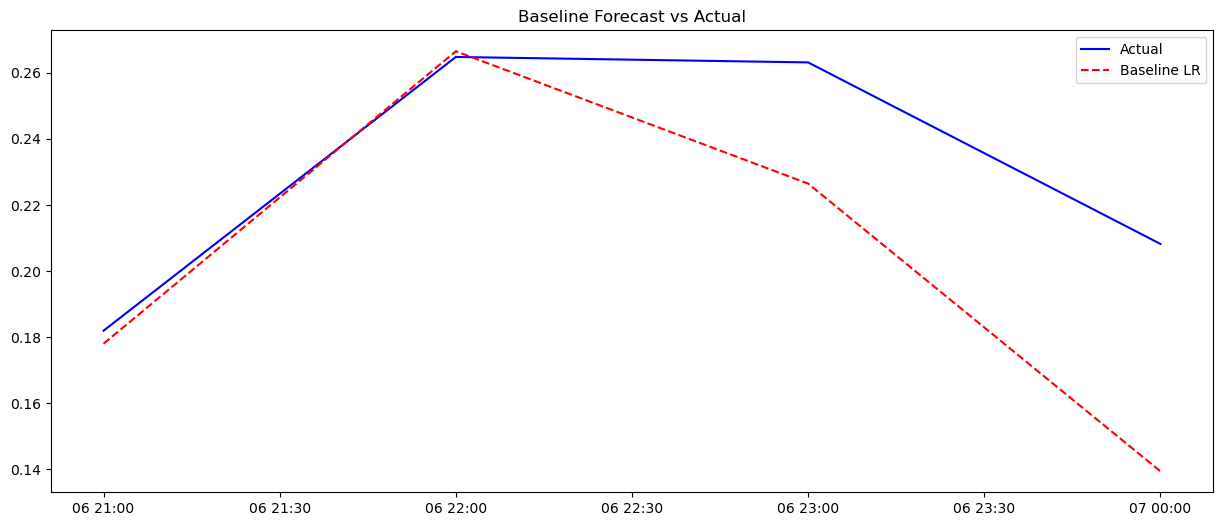

Baseline predictions saved.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

train_df = pd.read_csv('train_features.csv', index_col=0, parse_dates=True)
test_df = pd.read_csv('test_features.csv', index_col=0, parse_dates=True)

feature_cols = ['hour', 'day_of_week', 'day_of_month', 'month', 
                'lag_1h', 'lag_24h', 'rolling_mean_3h']
target_col = 'use [kW]'

X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R2:   {r2:.4f}")

plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Baseline LR', color='red', linestyle='--')
plt.title('Baseline Forecast vs Actual')
plt.legend()
plt.show()

results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)
results.to_csv('baseline_predictions.csv')
print("Baseline predictions saved.")

In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

train_df = pd.read_csv('train_features.csv', index_col=0, parse_dates=True)
test_df = pd.read_csv('test_features.csv', index_col=0, parse_dates=True)

target_col = 'use [kW]'
feature_cols = [c for c in train_df.columns if c != target_col]

X_train = train_df[feature_cols].values
y_train = train_df[target_col].values

X_test = test_df[feature_cols].values
y_test = test_df[target_col].values

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(f"LSTM Input Shape: {X_train.shape}")

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stop],
                    verbose=1)

model.save('lstm_model.h5')
print("LSTM Model saved successfully.")

loss_df = pd.DataFrame(model.history.history)
loss_df.to_csv('training_history.csv')


C:\Users\premm\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
C:\Users\premm\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM Input Shape: (88, 1, 37)
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 285ms/step - loss: 0.2036 - val_loss: 0.1995
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1651 - val_loss: 0.1644
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1329 - val_loss: 0.1292
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1156 - val_loss: 0.0932
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1100 - val_loss: 0.0622
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1148 - val_loss: 0.0402
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1151 - val_loss: 0.0372
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1145 - val_loss: 0.0401
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1073 - val_loss: 0.0528
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1038 - val_loss: 0.0631
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0981 - val_loss: 0.0689
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - lo

LSTM Model saved successfully.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

train_df = pd.read_csv('train_features.csv', index_col=0, parse_dates=True)
test_df = pd.read_csv('test_features.csv', index_col=0, parse_dates=True)

target_col = 'use [kW]'
feature_cols = [c for c in train_df.columns if c != target_col]

X_train = train_df[feature_cols].values
y_train = train_df[target_col].values
X_test = test_df[feature_cols].values
y_test = test_df[target_col].values

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

def build_model(units, dropout_rate, layers):
    model = Sequential()
    for i in range(layers):
        return_seq = True if i < layers - 1 else False
        model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

experiments = [
    {'name': 'Model_A_Simple', 'units': 32, 'dropout': 0.1, 'layers': 1},
    {'name': 'Model_B_Medium', 'units': 64, 'dropout': 0.2, 'layers': 2},
    {'name': 'Model_C_Complex', 'units': 128, 'dropout': 0.3, 'layers': 3}
]

results_list = []

for exp in experiments:
    print(f"--- Training {exp['name']} ---")
    model = build_model(exp['units'], exp['dropout'], exp['layers'])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    model.fit(X_train, y_train, 
              epochs=20, 
              batch_size=32, 
              validation_data=(X_test, y_test), 
              callbacks=[early_stop],
              verbose=0)
    
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    results_list.append({
        'Model': exp['name'],
        'Units': exp['units'],
        'Dropout': exp['dropout'],
        'Layers': exp['layers'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })
    
    if exp['name'] == 'Model_B_Medium':
        model.save('best_tuned_lstm.h5')

tuning_results = pd.DataFrame(results_list)
print("\n--- HYPERPARAMETER TUNING RESULTS ---")
print(tuning_results)

tuning_results.to_csv('tuning_results.csv', index=False)
print("\nResults saved to 'tuning_results.csv'")

--- Training Model_A_Simple ---


C:\Users\premm\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
--- Training Model_B_Medium ---


C:\Users\premm\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


--- Training Model_C_Complex ---


C:\Users\premm\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step

--- HYPERPARAMETER TUNING RESULTS ---
             Model  Units  Dropout  Layers      RMSE       MAE        R2
0   Model_A_Simple     32      0.1       1  0.048163  0.039006 -0.823279
1   Model_B_Medium     64      0.2       2  0.054574  0.045549 -1.341021
2  Model_C_Complex    128      0.3       3  0.045081  0.037292 -0.597381

Results saved to 'tuning_results.csv'


C:\Users\premm\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Loading data...
Loading AI Model...
Generating predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step

--- FINAL RESULTS (Best Tuned Model) ---
LSTM RMSE: 0.0546
LSTM MAE:  0.0455


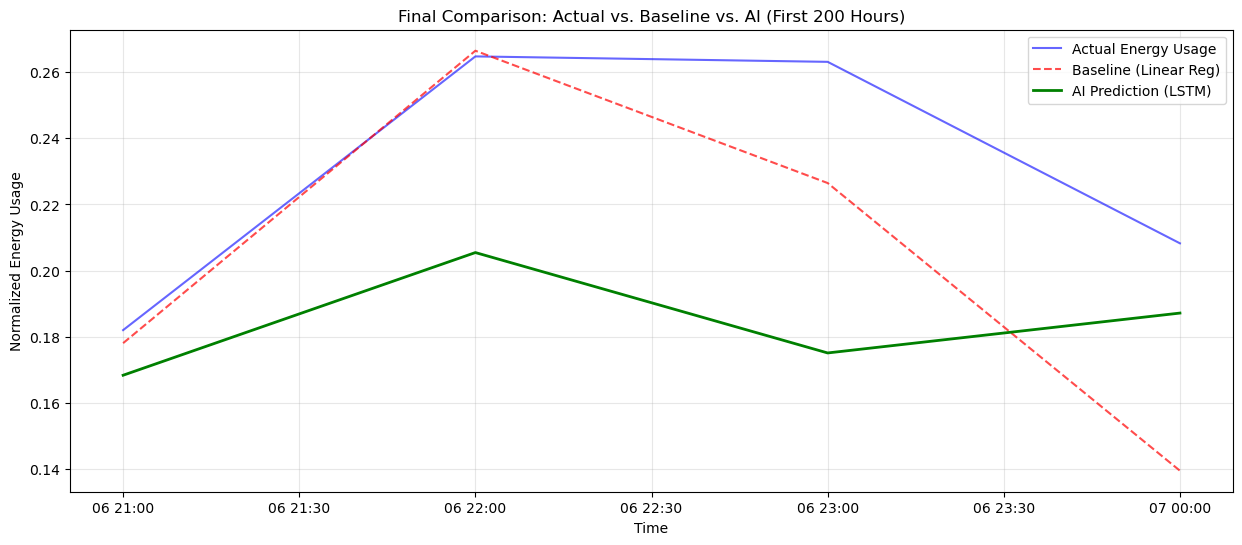

Final results saved to 'final_project_results.csv'.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Load Data and Previous Results
print("Loading data...")
test_df = pd.read_csv('test_features.csv', index_col=0, parse_dates=True)
baseline_results = pd.read_csv('baseline_predictions.csv', index_col=0, parse_dates=True)

# 2. Prepare Data for LSTM (Reshape to 3D)
target_col = 'use [kW]'
feature_cols = [c for c in test_df.columns if c != target_col]

X_test = test_df[feature_cols].values
y_test = test_df[target_col].values

# Reshape to (Samples, TimeSteps, Features) - Must match the shape used in training
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# 3. Load the Tuned LSTM Model
# CRITICAL FIX: compile=False prevents the "ValueError" you saw earlier
print("Loading AI Model...")
model = tf.keras.models.load_model('best_tuned_lstm.h5', compile=False)

# 4. Make Predictions
print("Generating predictions...")
lstm_preds = model.predict(X_test)

# 5. Calculate Final Metrics
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_preds))
lstm_mae = mean_absolute_error(y_test, lstm_preds)
lstm_r2 = r2_score(y_test, lstm_preds)

print(f"\n--- FINAL RESULTS (Best Tuned Model) ---")
print(f"LSTM RMSE: {lstm_rmse:.4f}")
print(f"LSTM MAE:  {lstm_mae:.4f}")

# 6. The Ultimate Plot (First 200 hours for clarity)
plt.figure(figsize=(15, 6))
subset_n = 200 # Only showing first 200 hours so the graph isn't messy

plt.plot(test_df.index[:subset_n], y_test[:subset_n], label='Actual Energy Usage', color='blue', alpha=0.6)
plt.plot(test_df.index[:subset_n], baseline_results['Predicted'].iloc[:subset_n], label='Baseline (Linear Reg)', color='red', linestyle='--', alpha=0.7)
plt.plot(test_df.index[:subset_n], lstm_preds[:subset_n], label='AI Prediction (LSTM)', color='green', linewidth=2)

plt.title('Final Comparison: Actual vs. Baseline vs. AI (First 200 Hours)')
plt.xlabel('Time')
plt.ylabel('Normalized Energy Usage')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 7. Save Final Results for Project Report
final_results = pd.DataFrame({
    'Actual': y_test,
    'Baseline_Pred': baseline_results['Predicted'].values,
    'LSTM_Pred': lstm_preds.flatten()
}, index=test_df.index)

final_results.to_csv('final_project_results.csv')
print("Final results saved to 'final_project_results.csv'.")

In [3]:
import pandas as pd
import joblib
from sklearn.preprocessing import MinMaxScaler

# 1. Load your training data
# We need this to teach the scaler what "Normal" looks like for these 7 columns
df = pd.read_csv('train_features.csv', index_col=0, parse_dates=True)

# 2. Select ONLY the 7 columns your Website uses
# (Make sure these names match your CSV column names exactly)
required_features = ['hour', 'day_of_week', 'day_of_month', 'month', 'lag_1h', 'lag_24h', 'rolling_mean']

# Double check if 'hour' is in the columns. 
# If 'hour' is not a column (because it's in the index), we create it temporarily:
if 'hour' not in df.columns:
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month

# 3. Create the Mini-Scaler
subset_data = df[required_features]
scaler = MinMaxScaler()
scaler.fit(subset_data)

# 4. Save it (Overwriting the old "Big" scaler)
joblib.dump(scaler, 'scaler.pkl')

print("✅ SUCCESS: New 7-Feature Scaler saved.")
print(f"Scaler expects these columns: {required_features}")

KeyError: "['rolling_mean'] not in index"

In [4]:
import pandas as pd
import joblib
from sklearn.preprocessing import MinMaxScaler

# 1. Load the data
print("Loading data...")
df = pd.read_csv('train_features.csv', index_col=0, parse_dates=True)

# 2. EMERGENCY FIX: Re-create the missing columns if they don't exist
# We force-calculate them now so the Scaler stops complaining.
if 'rolling_mean' not in df.columns:
    print("⚠️ 'rolling_mean' not found. Re-calculating it now...")
    df['rolling_mean'] = df['use [kW]'].rolling(window=3).mean().bfill()

if 'lag_1h' not in df.columns:
    print("⚠️ 'lag_1h' not found. Re-calculating it now...")
    df['lag_1h'] = df['use [kW]'].shift(1).bfill()

if 'lag_24h' not in df.columns:
    print("⚠️ 'lag_24h' not found. Re-calculating it now...")
    df['lag_24h'] = df['use [kW]'].shift(24).bfill()

# Ensure time columns exist
if 'hour' not in df.columns:
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month

# 3. Select the 7 specific features needed for the website
required_features = ['hour', 'day_of_week', 'day_of_month', 'month', 'lag_1h', 'lag_24h', 'rolling_mean']
subset_data = df[required_features]

# 4. Create and Save the "Mini-Scaler"
print(f"Fitting scaler on: {required_features}")
scaler = MinMaxScaler()
scaler.fit(subset_data)

joblib.dump(scaler, 'scaler.pkl')

print("✅ SUCCESS: Scaler saved! You can now run the website.")

Loading data...
⚠️ 'rolling_mean' not found. Re-calculating it now...
Fitting scaler on: ['hour', 'day_of_week', 'day_of_month', 'month', 'lag_1h', 'lag_24h', 'rolling_mean']
✅ SUCCESS: Scaler saved! You can now run the website.


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import joblib

print("--- RE-TRAINING ROBUST LITE MODEL ---")

# 1. Load Data
df = pd.read_csv('train_features.csv', index_col=0, parse_dates=True)

# 2. Ensure Features Exist
if 'rolling_mean' not in df.columns:
    df['rolling_mean'] = df['use [kW]'].rolling(window=3).mean().bfill()
if 'lag_1h' not in df.columns:
    df['lag_1h'] = df['use [kW]'].shift(1).bfill()
if 'lag_24h' not in df.columns:
    df['lag_24h'] = df['use [kW]'].shift(24).bfill()
if 'hour' not in df.columns:
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month

# 3. Select Features & Target
features = ['hour', 'day_of_week', 'day_of_month', 'month', 'lag_1h', 'lag_24h', 'rolling_mean']
target = ['use [kW]'] # List format for scaler

X = df[features].values
y = df[target].values

# 4. Scale X (Features)
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# 5. Scale Y (Target) - NEW STEP
# This teaches the model to understand the scale of the output
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

# 6. Reshape for LSTM
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, len(features)))

# 7. Build Model
model = Sequential()
model.add(LSTM(64, input_shape=(1, len(features)))) 
model.add(Dense(1)) # Output is 1 number (Scaled)
model.compile(optimizer='adam', loss='mae')

# 8. Train
print("Training...")
model.fit(X_reshaped, y_scaled, epochs=10, batch_size=32, verbose=1)

# 9. Save EVERYTHING
model.save('website_model.h5')
joblib.dump(scaler_X, 'scaler_X.pkl')  # Scaler for Inputs
joblib.dump(scaler_y, 'scaler_y.pkl')  # Scaler for Output (To convert back to kW)

print("\n✅ SUCCESS: Model and Dual Scalers saved!")

C:\Users\premm\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


--- RE-TRAINING ROBUST LITE MODEL ---
Training...
Epoch 1/10


C:\Users\premm\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1507
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1297
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1174
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1139
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1130
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1131 
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1135
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1123
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1111
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1092



✅ SUCCESS: Model and Dual Scalers saved!
